In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sqlite3
from scipy.stats import ttest_ind # for hypothesis testing
import scipy.stats as stats
warnings.filterwarnings('ignore')

In [31]:
#creating database connection
con = sqlite3.connect('inventory.db')

#fetching vendor summary data
df = pd.read_sql_query("SELECT * FROM vendor_sales_summary", con)
df.head()

,VendorNumber,VendorName,Brand,Description,PurchasePrice,Volume,ActualPrice,TotalPurchaseQuantity,TotalPurchaseDollars,TotalSalesDollars,TotalSalesQuantity,TotalSalesPrice,TotalExciseTax,FreightCost,GrossProfit,ProfitMargin,StockTurnover,SalesToPurchaseRatio
0,1128,BROWN-FORMAN CORP,1233,Jack Daniels No 7 Black,26.27,1750.0,36.99,145080,3811251.60,5101919.51,142049.0,672819.31,260999.20,68601.68,1290667.91,25.297693,0.979108,1.338647
1,4425,MARTIGNETTI COMPANIES,3405,Tito's Handmade Vodka,23.19,1750.0,28.99,164038,3804041.22,4819073.49,160247.0,561512.37,294438.66,144929.24,1015032.27,21.062810,0.976890,1.266830
2,17035,PERNOD RICARD USA,8068,Absolut 80 Proof,18.24,1750.0,24.99,187407,3418303.68,4538120.60,187140.0,461140.15,343854.07,123780.22,1119816.92,24.675786,0.998575,1.327594
3,3960,DIAGEO NORTH AMERICA INC,4261,Capt Morgan Spiced Rum,16.17,1750.0,22.99,201682,3261197.94,4475972.88,200412.0,420050.01,368242.80,257032.07,1214774.94,27.139908,0.993703,1.372493
4,3960,DIAGEO NORTH AMERICA INC,3545,Ketel One Vodka,21.89,1750.0,29.99,138109,3023206.01,4223107.62,135838.0,545778.28,249587.83,257032.07,1199901.61,28.412764,0.983556,1.396897


### **Exploratory Data Analysis**

Previously we examined various tables in the database to identify key variables, understand their relationship, and determine which ones should be included in the final analysis.
In this phase of EDA, we will analyze the resultant table to gain insights into the distribution of each column. This will help us understand data patterns, identify anomalies and ensure data quality before proceeding with further analysis.

In [32]:
# summary statistics
df.describe().T
# transposing the dataframe

,count,mean,std,min,25%,50%,75%,max
VendorNumber,10692.0,1.065065e+04,18753.519148,2.00,3951.000000,7153.000000,9552.000000,2.013590e+05
Brand,10692.0,1.803923e+04,12662.187074,58.00,5793.500000,18761.500000,25514.250000,9.063100e+04
PurchasePrice,10692.0,2.438530e+01,109.269375,0.36,6.840000,10.455000,19.482500,5.681810e+03
Volume,10692.0,8.473605e+02,664.309212,50.00,750.000000,750.000000,750.000000,2.000000e+04
ActualPrice,10692.0,3.564367e+01,148.246016,0.49,10.990000,15.990000,28.990000,7.499990e+03
TotalPurchaseQuantity,10692.0,3.140887e+03,11095.086769,1.00,36.000000,262.000000,1975.750000,3.376600e+05
TotalPurchaseDollars,10692.0,3.010669e+04,123067.799627,0.71,453.457500,3655.465000,20738.245000,3.811252e+06
TotalSalesDollars,10692.0,4.223907e+04,167655.265984,0.00,729.220000,5298.045000,28396.915000,5.101920e+06
TotalSalesQuantity,10692.0,3.077482e+03,10952.851391,0.00,33.000000,261.000000,1929.250000,3.349390e+05
TotalSalesPrice,10692.0,1.879378e+04,44952.773386,0.00,289.710000,2857.800000,16059.562500,6.728193e+05


1. Gross profit ---- Min is -₹52,002 – means loss is happening for some products.
2. ProfitMargin ---- Min is -inf, mean is also -inf, and std is NaN – this metric is likely miscalculated for rows where sales = 0 or purchase = 0.
3. We can see 0 for totalsalesquantity, which means the product was bought but they did not sell it.
4. every column has 10692 entires, which means no missing data.

5. PurchasePrice ---- Min is ₹0.36 and max is ₹5681 – very wide range, some items are super cheap, others very expensive.
6. ActualPrice ---- Ranges from ₹0.49 to ₹7499 – again, wide pricing.
7. TotalPurchaseDollars ---- Huge spread (₹0.71 to ₹3.8 million) – indicates some vendors/brands buy in bulk.
8. SalesToPurchaseRatio/StockTurnover ----- Some values are 0 – sales not happening after purchase; some go as high as 3.5 – good turnover for some items.

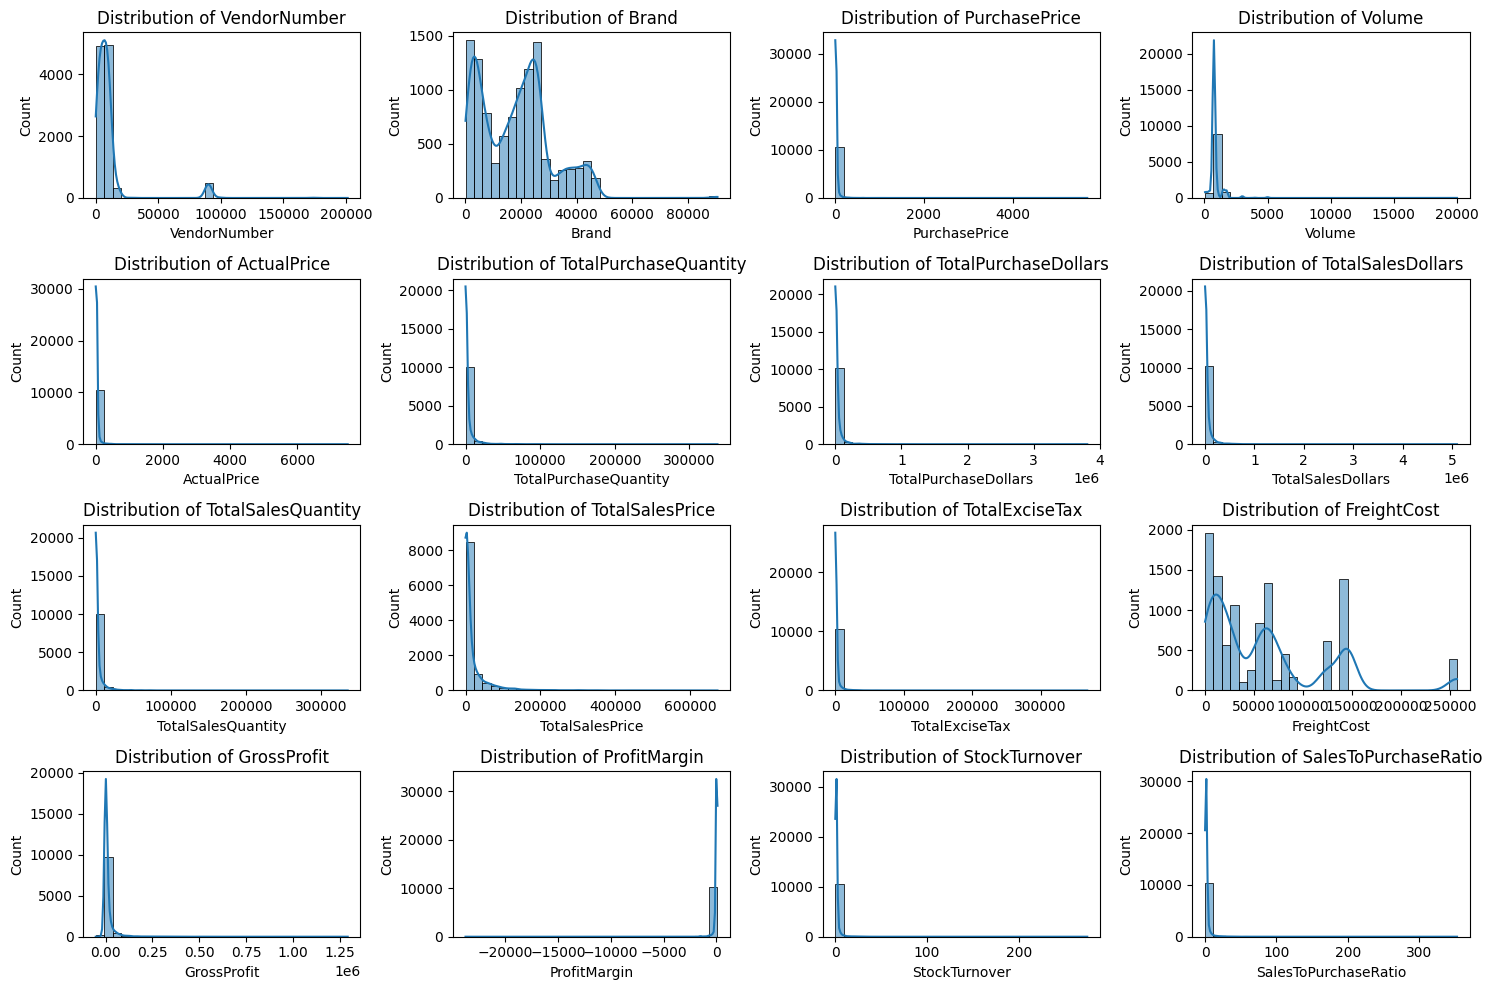

In [33]:
# to check for outliers
# Distribution plots for numerical columns

numerical_columns = df.select_dtypes(include=np.number).columns

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_columns):
    plt.subplot(4, 4, i+1) # grid of 4 rows and 4 columns
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

**Top 5 Variables with Strong Outlier Influence:**
1. ProfitMargin – Contains -inf, massive negative values → likely due to division by zero.

2. TotalPurchaseQuantity – Goes up to 3.37 lakh while 75% are under 2000 → high outliers.

3. GrossProfit – Negative values and extreme positive values > ₹10 lakh.

4. FreightCost – Multi-modal with outliers > ₹2.5 lakh → cost management issue, suggest logistics inefficiencies or bulk shipments.

5. TotalSalesDollars – A few extreme sales dominate; heavy right skew.

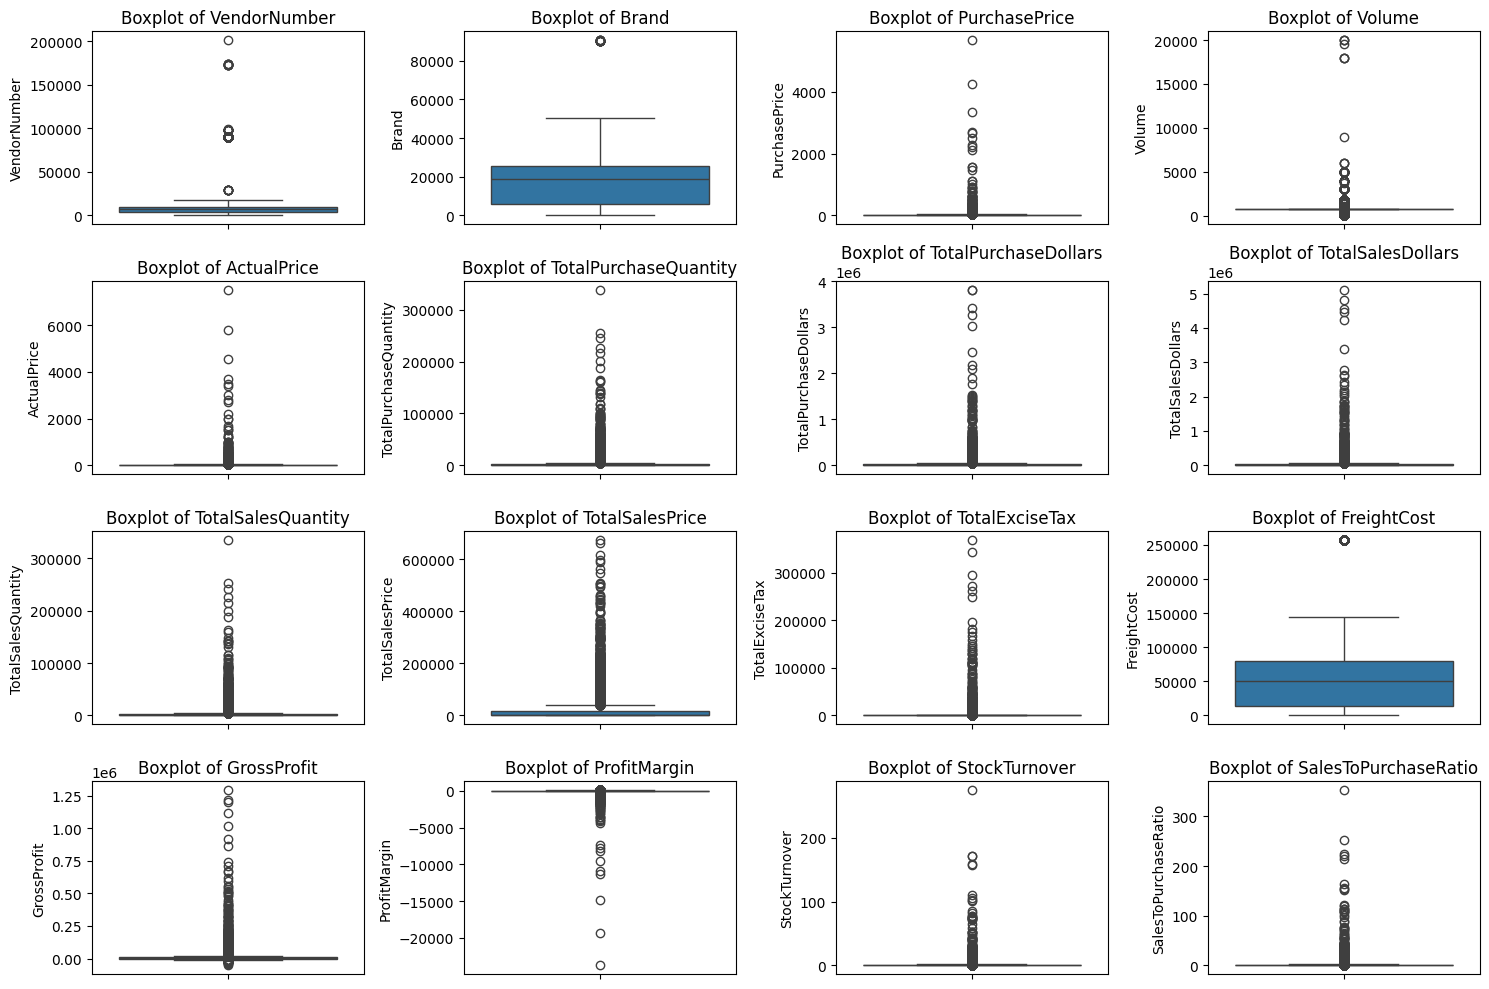

In [34]:
# box plot for outliers
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_columns):
    plt.subplot(4, 4, i+1)
    sns.boxplot(df[col], orient='v')
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

In [35]:
# we will be filtering out the data where the value is 0 or less, in case of GrossProfit, ProfitMargin and TotalsalesQuantity.
df = pd.read_sql_query("""SELECT * 
FROM vendor_sales_summary
WHERE GrossProfit > 0 
AND ProfitMargin > 0 
AND TotalsalesQuantity > 0""", con)

In [36]:
df.shape

(8564, 18)

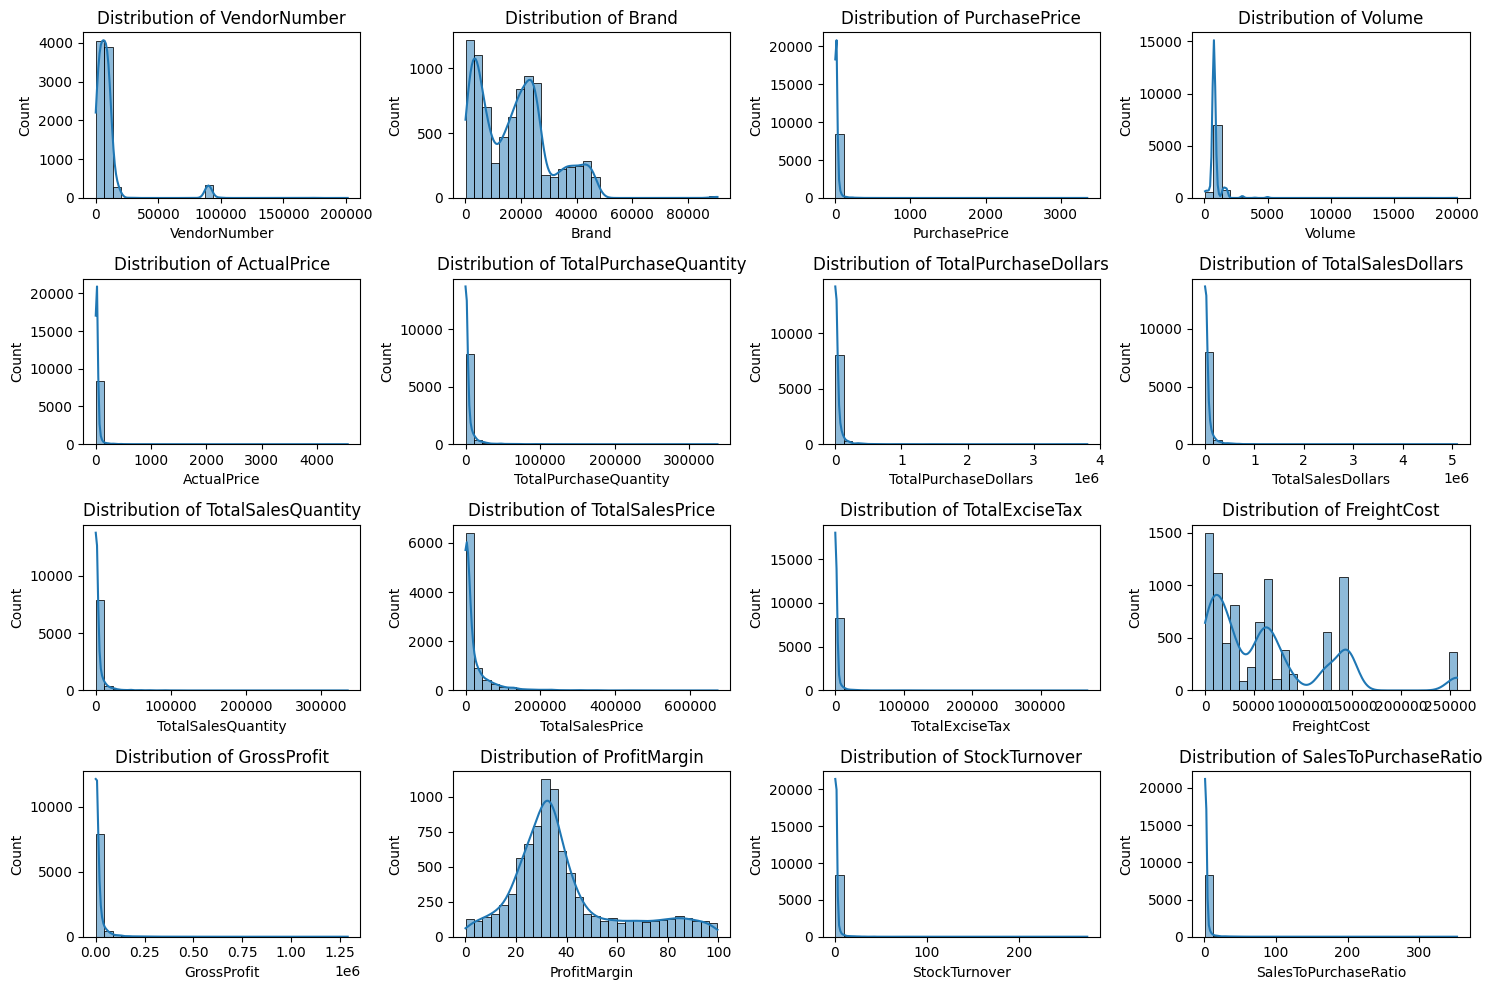

In [37]:
numerical_columns = df.select_dtypes(include=np.number).columns

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_columns):
    plt.subplot(4, 4, i+1) # grid of 4 rows and 4 columns
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

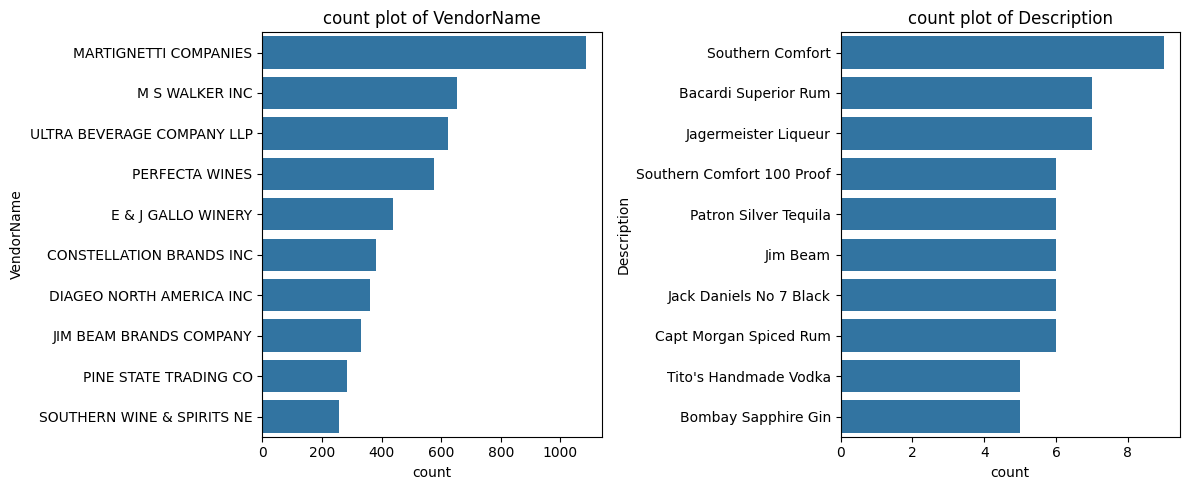

In [38]:
# Count plot for categorical columns
categorical_col = ["VendorName", "Description"]

plt.figure(figsize=(12, 5))
for i, col in enumerate(categorical_col):
    plt.subplot(1, 2, i+1) # grid of 1 row and 2 columns
    sns.countplot(y=df[col], order=df[col].value_counts().index[:10])
    plt.title(f'count plot of {col}') # top 10 categories
plt.tight_layout()
plt.show()

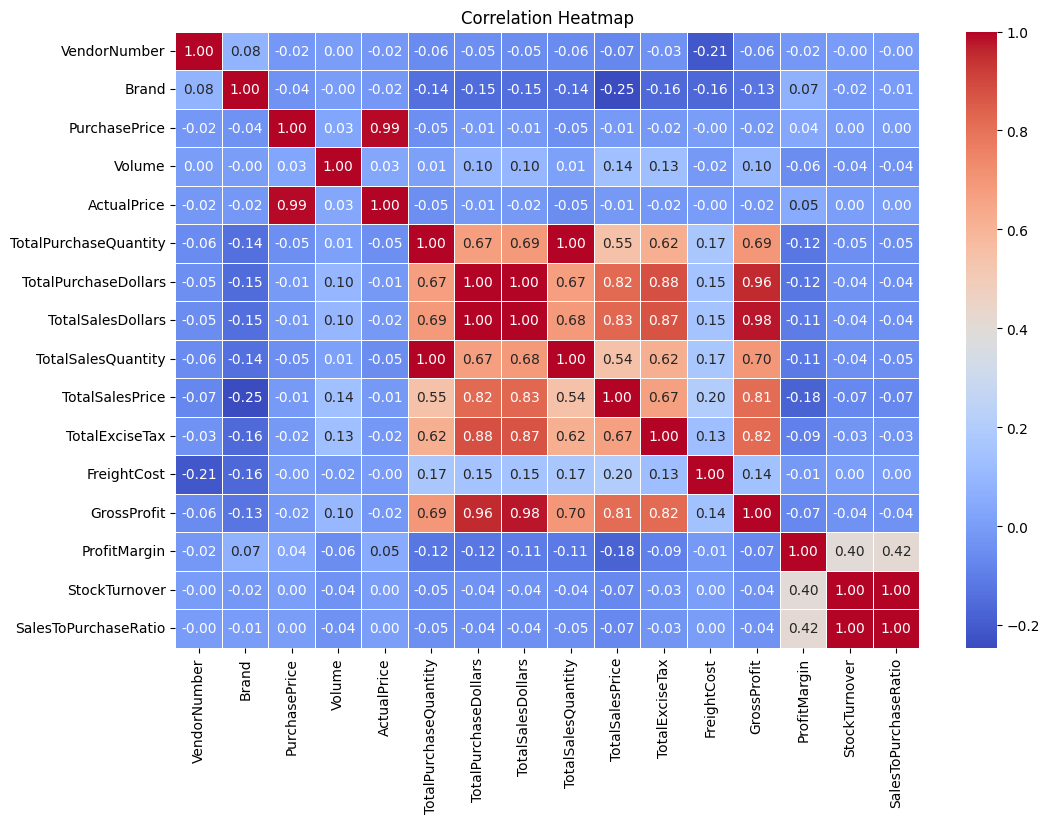

In [39]:
# heatmap for correlation
plt.figure(figsize=(12, 8))
corr = df[numerical_columns].corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

**Correlation Insights**
1. PurchasePrice has a weak corr with TotalSalesDollars and Grossrofit, suggesting that price variations do not significantly impact sales revenue or profit.
2. Strong corr between purchase quantity and total sales quantity, confirming efficient inventory turnover. what’s purchased is mostly sold. Efficient stock usage.
3. Negative corr between profitmargin and total sales price suggests that as sales price increases, margin decreases, possibly due to competitive pricing pressure.
4. Stock Turnover has weak negative correlation with both grossprofit and profitmargin, indicating that faster turnover doesnt necesarrily result in high profitablity.


## DATA ANALYSIS

**1. Identify brands that need Promotional or Pricing adjustments which exhibit lower sales performance but higher profit margins.**

In [40]:
brand_performance = df.groupby('Description').agg({
    'TotalSalesDollars':'sum',
    'ProfitMargin':'mean'   # as it is in percentage
}).reset_index()

In [41]:
# calculating brand score
# we need to set a threshold for the brand score, for those who need a promotional campaign
low_sales_threshold = brand_performance['TotalSalesDollars'].quantile(0.15)
high_margin_threshold = brand_performance['ProfitMargin'].quantile(0.85)

In [42]:
low_sales_threshold

560.299

In [43]:
high_margin_threshold?

Type:        float64
String form: 64.97017552750113
File:        c:\users\hp\appdata\local\programs\python\python312\lib\site-packages\numpy\__init__.py
Docstring:  
Double-precision floating-point number type, compatible with Python `float`
and C ``double``.

:Character code: ``'d'``
:Canonical name: `numpy.double`
:Alias: `numpy.float_`
:Alias on this platform (win32 AMD64): `numpy.float64`: 64-bit precision floating-point number type: sign bit, 11 bits exponent, 52 bits mantissa.

In [44]:
# filtering brands with low sales but high profit margins
target_brands = brand_performance[
    (brand_performance['TotalSalesDollars'] <= low_sales_threshold) &
    (brand_performance['ProfitMargin'] >= high_margin_threshold)
]
print(f"Number of brands with low sales but high profit margins: {len(target_brands)}")
display(target_brands.sort_values('TotalSalesDollars'))

Number of brands with low sales but high profit margins: 198


,Description,TotalSalesDollars,ProfitMargin
6199,Santa Rita Organic Svgn Bl,9.99,66.466466
2369,Debauchery Pnt Nr,11.58,65.975820
2070,Concannon Glen Ellen Wh Zin,15.95,83.448276
2188,Crown Royal Apple,27.86,89.806174
6237,Sauza Sprklg Wild Berry Marg,27.96,82.153076
...,...,...,...
5074,Nanbu Bijin Southern Beauty,535.68,76.747312
2271,Dad's Hat Rye Whiskey,538.89,81.851584
57,A Bichot Clos Marechaudes,539.94,67.740860
6245,Sbragia Home Ranch Merlot,549.75,66.444748


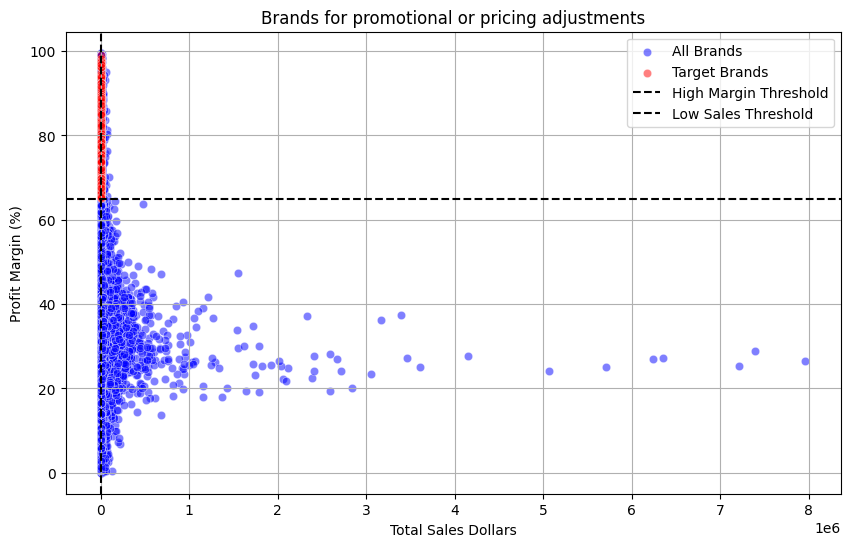

In [45]:
# scatter plot of sales vs profit margin
plt.figure(figsize=(10, 6))
sns.scatterplot(x='TotalSalesDollars', y='ProfitMargin', data=brand_performance, alpha=0.5, color='blue', label='All Brands')
sns.scatterplot(x='TotalSalesDollars', y='ProfitMargin', data=target_brands, alpha=0.5, color='red', label='Target Brands')

plt.axhline(high_margin_threshold, color='black', linestyle='--', label='High Margin Threshold')
plt.axvline(low_sales_threshold, color='black', linestyle='--', label='Low Sales Threshold')

plt.title('Brands for promotional or pricing adjustments')
plt.xlabel('Total Sales Dollars')
plt.ylabel('Profit Margin (%)')
plt.legend()
plt.grid(True)
plt.show()

In [46]:
brand_performance = brand_performance[brand_performance['TotalSalesDollars'] < 10000]
# for better visualization

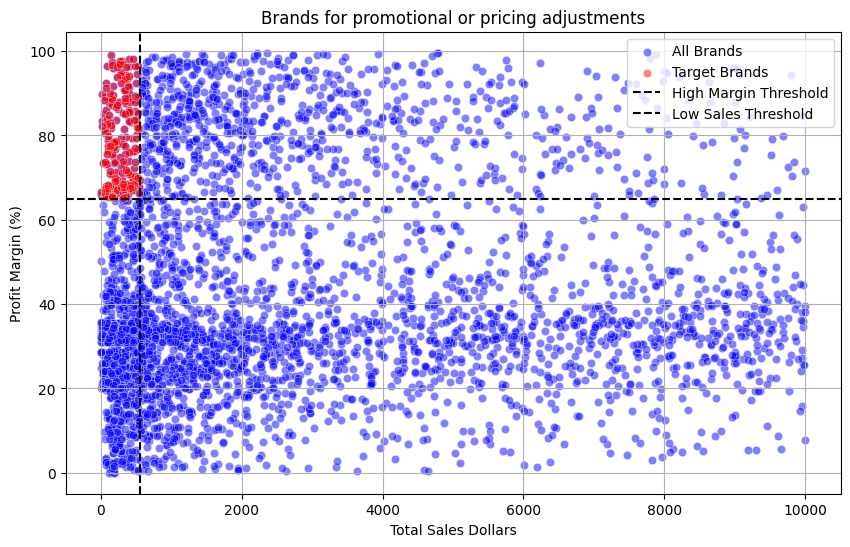

In [47]:
# scatter plot of sales vs profit margin
plt.figure(figsize=(10, 6))
sns.scatterplot(x='TotalSalesDollars', y='ProfitMargin', data=brand_performance, alpha=0.5, color='blue', label='All Brands')
sns.scatterplot(x='TotalSalesDollars', y='ProfitMargin', data=target_brands, alpha=0.5, color='red', label='Target Brands')

plt.axhline(high_margin_threshold, color='black', linestyle='--', label='High Margin Threshold')
plt.axvline(low_sales_threshold, color='black', linestyle='--', label='Low Sales Threshold')

plt.title('Brands for promotional or pricing adjustments')
plt.xlabel('Total Sales Dollars')
plt.ylabel('Profit Margin (%)')
plt.legend()
plt.grid(True)
plt.show()

**2. Which vendor and brands demonstrate the hightes sales performance?**

In [48]:
# top vendors and brands by sales performance
top_vendors = df.groupby("VendorName")["TotalSalesDollars"].sum().nlargest(10)
top_brands = df.groupby("Description")["TotalSalesDollars"].sum().nlargest(10)


In [49]:
# function for formating
def format_dollars(value):
    if value >= 1_000_000:
        return f"{value/1_000_000:.2f}M"
    elif value >= 1_000:
        return f"{value/1_000:.2f}K"
    else:
        return str(value)

In [50]:
top_vendors

VendorName
DIAGEO NORTH AMERICA INC      67990099.42
MARTIGNETTI COMPANIES         39330359.36
PERNOD RICARD USA             32063196.19
JIM BEAM BRANDS COMPANY       31423020.46
BACARDI USA INC               24854817.14
CONSTELLATION BRANDS INC      24218745.65
E & J GALLO WINERY            18399899.46
BROWN-FORMAN CORP             18247230.65
ULTRA BEVERAGE COMPANY LLP    16502544.31
M S WALKER INC                14706458.51
Name: TotalSalesDollars, dtype: float64

In [51]:
top_brands

Description
Jack Daniels No 7 Black    7964746.76
Tito's Handmade Vodka      7399657.58
Grey Goose Vodka           7209608.06
Capt Morgan Spiced Rum     6356320.62
Absolut 80 Proof           6244752.03
Jameson Irish Whiskey      5715759.69
Ketel One Vodka            5070083.56
Baileys Irish Cream        4150122.07
Kahlua                     3604858.66
Tanqueray                  3456697.90
Name: TotalSalesDollars, dtype: float64

In [52]:
top_brands.apply(lambda x: format_dollars(x))

Description
Jack Daniels No 7 Black    7.96M
Tito's Handmade Vodka      7.40M
Grey Goose Vodka           7.21M
Capt Morgan Spiced Rum     6.36M
Absolut 80 Proof           6.24M
Jameson Irish Whiskey      5.72M
Ketel One Vodka            5.07M
Baileys Irish Cream        4.15M
Kahlua                     3.60M
Tanqueray                  3.46M
Name: TotalSalesDollars, dtype: object

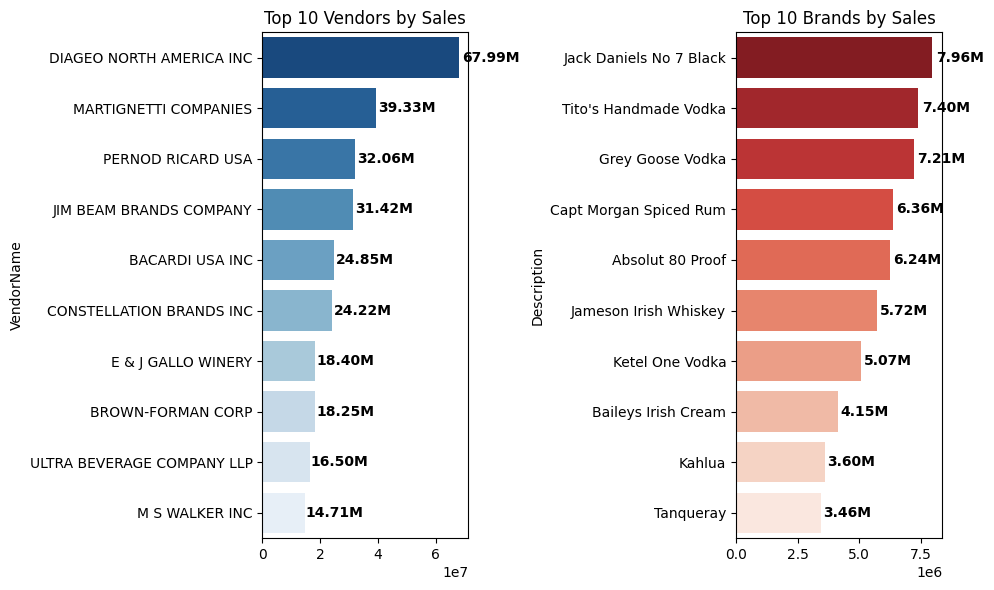

In [53]:
plt.figure(figsize=(10, 6))

# plot for top vendors
plt.subplot(1, 2, 1)
ax1 = sns.barplot(y=top_vendors.index, x=top_vendors.values, palette="Blues_r")
plt.title("Top 10 Vendors by Sales")

for bar in ax1.patches:
    ax1.text(bar.get_width() + (bar.get_width() * 0.02),
    bar.get_y() + bar.get_height() / 2,
    format_dollars(bar.get_width()),
    ha="left", va="center", fontsize=10, color="black", weight="bold")


# plot for top brands
plt.subplot(1, 2, 2)
ax2 = sns.barplot(y=top_brands.index.astype(str), x=top_brands.values, palette="Reds_r")
plt.title("Top 10 Brands by Sales")

for bar in ax2.patches:
    ax2.text(bar.get_width() + (bar.get_width() * 0.02),
    bar.get_y() + bar.get_height() / 2,
    format_dollars(bar.get_width()),
    ha="left", va="center", fontsize=10, color="black", weight="bold")


plt.tight_layout()
plt.show()

**3. which vendors contribute the most to total purchase dollars?**

In [54]:
vendor_contribution = df.groupby("VendorName").agg({
    "TotalPurchaseDollars": "sum",
    "GrossProfit": "sum",
    "TotalSalesDollars": "sum"
}).reset_index()

In [65]:
vendor_contribution['PurchaseContribution(%)'] = vendor_contribution['TotalPurchaseDollars'] / vendor_contribution['TotalPurchaseDollars'].sum()*100

In [66]:
vendor_contribution = round(vendor_contribution.sort_values('PurchaseContribution(%)', ascending=False), 2)

In [67]:
vendor_contribution

,VendorName,TotalPurchaseDollars,GrossProfit,TotalSalesDollars,PurchaseContribution(%)
25,DIAGEO NORTH AMERICA INC,50097226.16,17892873.26,67990099.42,16.30
57,MARTIGNETTI COMPANIES,25502095.83,13828263.53,39330359.36,8.30
68,PERNOD RICARD USA,23851164.17,8212032.02,32063196.19,7.76
46,JIM BEAM BRANDS COMPANY,23494304.32,7928716.14,31423020.46,7.64
6,BACARDI USA INC,17432020.26,7422796.88,24854817.14,5.67
...,...,...,...,...,...
33,FANTASY FINE WINES CORP,128.64,198.95,327.59,0.00
107,UNCORKED,118.74,58.20,176.94,0.00
85,SILVER MOUNTAIN CIDERS,77.18,265.33,342.51,0.00
16,CAPSTONE INTERNATIONAL,54.64,192.23,246.87,0.00


In [68]:
# display top 10 vendors by total purchase dollars
top_vendors = vendor_contribution.head(10)
top_vendors['TotalSalesDollars'] = top_vendors['TotalSalesDollars'].apply(format_dollars)
top_vendors['TotalPurchaseDollars'] = top_vendors['TotalPurchaseDollars'].apply(format_dollars)
top_vendors['GrossProfit'] = top_vendors['GrossProfit'].apply(format_dollars)

top_vendors

,VendorName,TotalPurchaseDollars,GrossProfit,TotalSalesDollars,PurchaseContribution(%)
25,DIAGEO NORTH AMERICA INC,50.10M,17.89M,67.99M,16.30
57,MARTIGNETTI COMPANIES,25.50M,13.83M,39.33M,8.30
68,PERNOD RICARD USA,23.85M,8.21M,32.06M,7.76
46,JIM BEAM BRANDS COMPANY,23.49M,7.93M,31.42M,7.64
6,BACARDI USA INC,17.43M,7.42M,24.85M,5.67
20,CONSTELLATION BRANDS INC,15.27M,8.95M,24.22M,4.97
11,BROWN-FORMAN CORP,13.24M,5.01M,18.25M,4.31
30,E & J GALLO WINERY,12.07M,6.33M,18.40M,3.93
106,ULTRA BEVERAGE COMPANY LLP,11.17M,5.34M,16.50M,3.63
53,M S WALKER INC,9.76M,4.94M,14.71M,3.18


In [69]:
# out of 119 vendors only 10 vendors are contributing nearly 66%
top_vendors['PurchaseContribution(%)'].sum()

65.69000000000001

In [70]:
top_vendors['Cumulative_Contribution'] = top_vendors['PurchaseContribution(%)'].cumsum()
top_vendors.head()

,VendorName,TotalPurchaseDollars,GrossProfit,TotalSalesDollars,PurchaseContribution(%),Cumulative_Contribution
25,DIAGEO NORTH AMERICA INC,50.10M,17.89M,67.99M,16.30,16.30
57,MARTIGNETTI COMPANIES,25.50M,13.83M,39.33M,8.30,24.60
68,PERNOD RICARD USA,23.85M,8.21M,32.06M,7.76,32.36
46,JIM BEAM BRANDS COMPANY,23.49M,7.93M,31.42M,7.64,40.00
6,BACARDI USA INC,17.43M,7.42M,24.85M,5.67,45.67


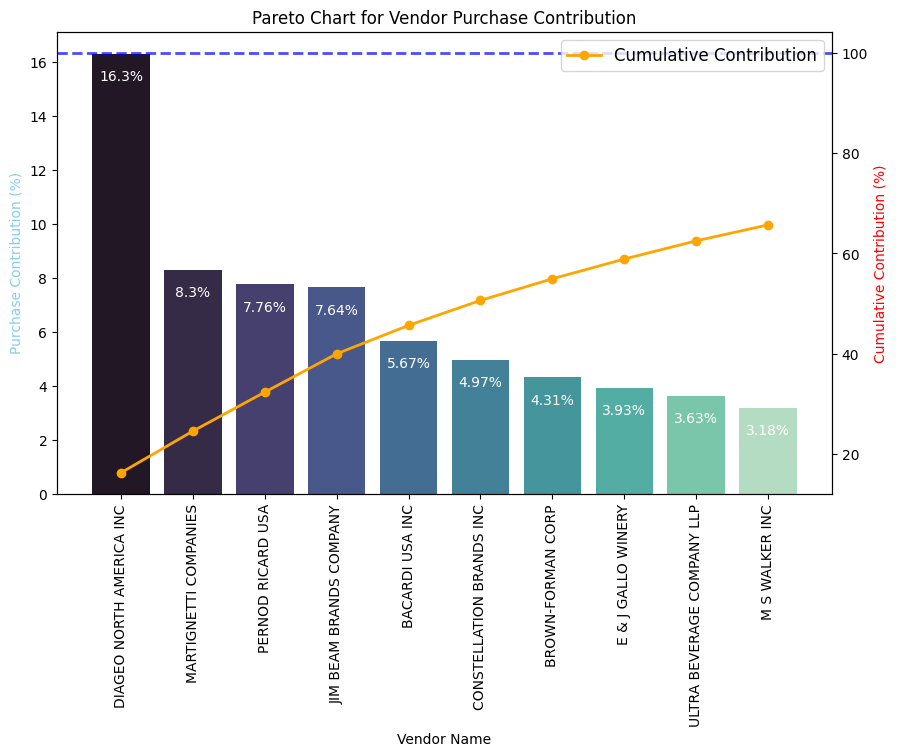

In [71]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar plot for Purchase Contribution
sns.barplot(x=top_vendors['VendorName'], y=top_vendors['PurchaseContribution(%)'], palette='mako', ax=ax1)

for i, value in enumerate(top_vendors['PurchaseContribution(%)']):
    ax1.text(i, value - 1, str(value) + '%', ha='center', fontsize=10, color = 'white')


ax1.set_xticklabels(top_vendors['VendorName'], rotation=90)
ax1.set_title('Pareto Chart for Vendor Purchase Contribution')
ax1.set_xlabel('Vendor Name')
ax1.set_ylabel('Purchase Contribution (%)', color='skyblue')



# Line plot for Cumulative Contribution
ax2 = ax1.twinx()
ax2.plot(top_vendors['VendorName'], top_vendors['Cumulative_Contribution'], color='orange', marker='o', linestyle='-', label='Cumulative Contribution', linewidth=2)

ax2.axhline(y=100, color='blue', linestyle='--', alpha=0.7, linewidth=2)
ax2.legend(loc='upper right', fontsize=12)
ax2.set_ylabel('Cumulative Contribution (%)', color = 'red')

plt.show()

**4. How much of total procurement is dependent on the top vendors?**

In [72]:
print(f"Total purchase contribution of top 10 vendors is {round(top_vendors['PurchaseContribution(%)'].sum(), 2)}%")

Total purchase contribution of top 10 vendors is 65.69%


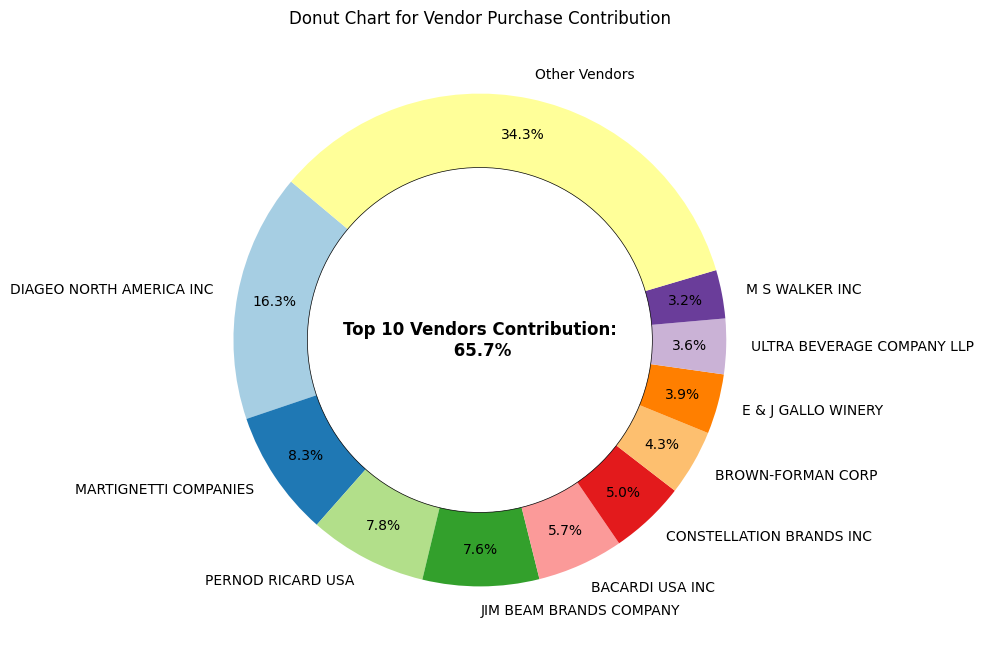

In [75]:
vendors = list(top_vendors['VendorName'].values)
purchase_contribution = list(top_vendors['PurchaseContribution(%)'].values)
total_contribution = sum(purchase_contribution)
remaining_contribution = 100 - total_contribution      # excluding top 10 vendors contribution

# Append other vendors to the list
vendors.append('Other Vendors')
purchase_contribution.append(remaining_contribution)

# Donut chart
fig, ax = plt.subplots(figsize=(8, 8))
wedges, texts, autotexts = ax.pie(purchase_contribution, labels=vendors, autopct='%1.1f%%', startangle=140, pctdistance=0.85, colors=plt.cm.Paired.colors)

# Draw circle in the center to make it look like a donut
center_circle = plt.Circle((0, 0), 0.70, fc='white', edgecolor='black', linewidth=0.5)
fig.gca().add_artist(center_circle)

# Add legend - Total contribution annotation in the center
plt.text(0, 0, f'Top 10 Vendors Contribution:\n {total_contribution:.1f}%', ha='center', va='center', fontsize=12, fontweight='bold')

plt.title("Donut Chart for Vendor Purchase Contribution")
plt.show()

**5. Does purchasing in bulk reduce the unit price, and what is the optimal purchase volume for cost savings?**

In [76]:
df['UnitPurchasePrice'] = df['TotalPurchaseDollars'] / df['TotalPurchaseQuantity']

In [ ]:
# Dividing the orders into three categories: Small, Medium, Large(based on quantiles), this will create 3 equal sized groups
df["OrderSize"] = pd.qcut(df["TotalPurchaseQuantity"], q=3, labels=["Small", "Medium", "Large"])

In [78]:
df[['OrderSize', 'TotalPurchaseQuantity']]

,OrderSize,TotalPurchaseQuantity
0,Large,145080
1,Large,164038
2,Large,187407
3,Large,201682
4,Large,138109
...,...,...
8559,Small,2
8560,Small,6
8561,Small,2
8562,Small,1


In [ ]:
# Average purchase price for each order size
df.groupby('OrderSize')[['UnitPurchasePrice']].mean()

,UnitPurchasePrice
OrderSize,
Small,39.068186
Medium,15.486414
Large,10.777625


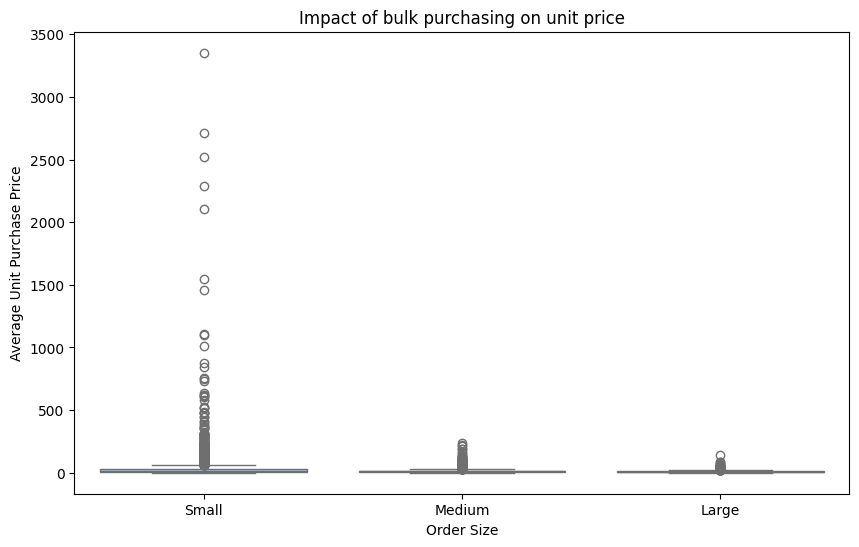

In [81]:
# Box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='OrderSize', y='UnitPurchasePrice', data=df, palette='pastel')
plt.title('Impact of bulk purchasing on unit price')
plt.xlabel('Order Size')
plt.ylabel('Average Unit Purchase Price')
plt.show()

1. Hence vendor buying in bulk (large order size) get the lowest unit price (10.77B per unit), meaning higher margins, if they can manage inventory efficiently.
2. The price difference between small and large orders is substantial(~72% reduction in unit cost)
3. This suggests that bulk pricing stratergies successfully encourage vendors to purchase in large volumes, leading to higher overall sales despite lower per-unit revenue

**6. Which vendors have low inventory turnover, indicating excess stock and slow-moving products?**

In [ ]:
df[df['StockTurnover'] < 1]
# these are the vendors with low stock turnover, meaning they are not selling their inventory fast enough

,VendorNumber,VendorName,Brand,Description,PurchasePrice,Volume,ActualPrice,TotalPurchaseQuantity,TotalPurchaseDollars,TotalSalesDollars,TotalSalesQuantity,TotalSalesPrice,TotalExciseTax,FreightCost,GrossProfit,ProfitMargin,StockTurnover,SalesToPurchaseRatio,UnitPurchasePrice,OrderSize
0,1128,BROWN-FORMAN CORP,1233,Jack Daniels No 7 Black,26.27,1750.0,36.99,145080,3811251.60,5101919.51,142049.0,672819.31,260999.20,68601.68,1290667.91,25.297693,0.979108,1.338647,26.27,Large
1,4425,MARTIGNETTI COMPANIES,3405,Tito's Handmade Vodka,23.19,1750.0,28.99,164038,3804041.22,4819073.49,160247.0,561512.37,294438.66,144929.24,1015032.27,21.062810,0.976890,1.266830,23.19,Large
2,17035,PERNOD RICARD USA,8068,Absolut 80 Proof,18.24,1750.0,24.99,187407,3418303.68,4538120.60,187140.0,461140.15,343854.07,123780.22,1119816.92,24.675786,0.998575,1.327594,18.24,Large
3,3960,DIAGEO NORTH AMERICA INC,4261,Capt Morgan Spiced Rum,16.17,1750.0,22.99,201682,3261197.94,4475972.88,200412.0,420050.01,368242.80,257032.07,1214774.94,27.139908,0.993703,1.372493,16.17,Large
4,3960,DIAGEO NORTH AMERICA INC,3545,Ketel One Vodka,21.89,1750.0,29.99,138109,3023206.01,4223107.62,135838.0,545778.28,249587.83,257032.07,1199901.61,28.412764,0.983556,1.396897,21.89,Large
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8191,653,STATE WINE & SPIRITS,24371,Tozai Typhoon Sake,10.45,720.0,15.99,6,62.70,79.95,5.0,79.95,0.55,8014.98,17.25,21.575985,0.833333,1.275120,10.45,Small
8201,9552,M S WALKER INC,398,S S Pierce Ninety Nine Gin,5.63,1000.0,7.49,11,61.93,67.41,9.0,7.49,9.45,55551.82,5.48,8.129358,0.818182,1.088487,5.63,Small
8202,1392,CONSTELLATION BRANDS INC,16916,R Mondavi Malbec Private Slt,5.15,750.0,7.99,12,61.80,85.90,10.0,34.96,1.12,79528.99,24.10,28.055879,0.833333,1.389968,5.15,Small
8242,8352,LUXCO INC,8629,Ezra Brooks Cinnamon Bourbon,11.02,1750.0,13.99,5,55.10,56.97,3.0,37.98,5.51,10261.60,1.87,3.282429,0.600000,1.033938,11.02,Small


In [84]:
df[df['StockTurnover'] < 1].groupby('VendorName')[['StockTurnover']].mean().sort_values(by='StockTurnover', ascending=True)

,StockTurnover
VendorName,
ALISA CARR BEVERAGES,0.615385
HIGHLAND WINE MERCHANTS LLC,0.708333
PARK STREET IMPORTS LLC,0.751306
Circa Wines,0.755676
Dunn Wine Brokers,0.766022
...,...
DISARONNO INTERNATIONAL LLC,0.975577
"PREMIUM PORT WINES, INC.",0.976077
TY KU LLC,0.976982


##### we can identify which vendor out of these is giving profit and which is not


**6. How much capital is locked in unsold inventory per vendor and which vendors contribute the most to it?**

## Hypothesis Testing and Confidence Interval

In [ ]:
df["UnsoldInventoryValue"] = (df["TotalPurchaseQuantity"] - df["TotalSalesQuantity"]) * df["PurchasePrice"]
print('Total unsold capital: ', format_dollars(df["UnsoldInventoryValue"].sum()))

Total unsold capital:  2.71M


In [86]:
# Aggregate Capital locked per vendor
inventory_value_per_vendor = df.groupby('VendorName')['UnsoldInventoryValue'].sum().reset_index()

# sort vendors with the highest capital locked
inventory_value_per_vendor = inventory_value_per_vendor.sort_values(by='UnsoldInventoryValue', ascending=False)
inventory_value_per_vendor['UnsoldInventoryValue'] = inventory_value_per_vendor['UnsoldInventoryValue'].apply(format_dollars)
inventory_value_per_vendor.head(10)

,VendorName,UnsoldInventoryValue
25,DIAGEO NORTH AMERICA INC,722.21K
46,JIM BEAM BRANDS COMPANY,554.67K
68,PERNOD RICARD USA,470.63K
116,WILLIAM GRANT & SONS INC,401.96K
30,E & J GALLO WINERY,228.28K
79,SAZERAC CO INC,198.44K
11,BROWN-FORMAN CORP,177.73K
20,CONSTELLATION BRANDS INC,133.62K
61,MOET HENNESSY USA INC,126.48K
77,REMY COINTREAU USA INC,118.60K


**7. What is the 95% confidence intervals for profit margins of top-performing and low-performing vendors?**

In [87]:
top_threshold = df['TotalSalesDollars'].quantile(0.75)
low_threshold = df['TotalSalesDollars'].quantile(0.25)

In [88]:
top_vendors = df[df['TotalSalesDollars'] >= top_threshold]["ProfitMargin"].dropna()
low_vendors = df[df['TotalSalesDollars'] <= low_threshold]["ProfitMargin"].dropna()

In [ ]:
top_vendors
# profit margin of top vendors

0       25.297693
1       21.062810
2       24.675786
3       27.139908
4       28.412764
          ...    
3523    79.684817
3681    85.782102
4751    93.085860
4920    95.012530
5050    94.271857
Name: ProfitMargin, Length: 2141, dtype: float64

In [90]:
low_vendors

5631     4.111764
5652     6.145626
5701    12.007271
5704     1.677308
5724     7.239599
          ...    
8559    83.448276
8560    96.436186
8561    25.252525
8562    98.974037
8563    99.166079
Name: ProfitMargin, Length: 2141, dtype: float64

In [91]:
# to calculate confidence interval
def confidence_interval(data, confidence=0.95):
    mean_val = np.mean(data)
    std_err = np.std(data, ddof=1)/np.sqrt(len(data))   # Standard error of the mean
    t_critical = stats.t.ppf((1+confidence)/2, df=len(data)-1)
    margin_of_error = t_critical * std_err
    return mean_val, mean_val - margin_of_error, mean_val + margin_of_error  # Deviation from the mean(mean_val - margin_of_error, mean_val + margin_of_error) is the confidence interval

Top vendors 95% confidence interval: (30.74, 31.61), Mean: 31.18
Low vendors 95% confidence interval: (40.50, 42.64), Mean: 41.57


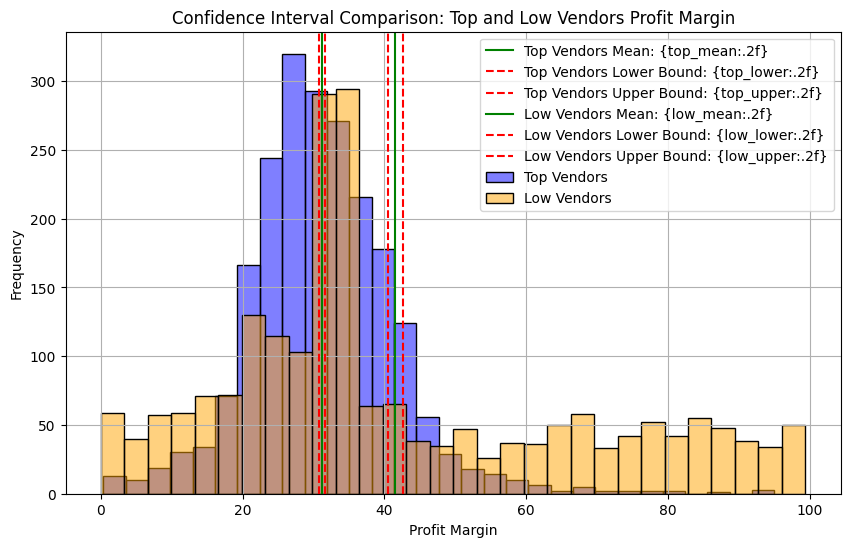

In [97]:
# plot
top_mean, top_lower, top_upper = confidence_interval(top_vendors)
low_mean, low_lower, low_upper = confidence_interval(low_vendors)

print(f"Top vendors 95% confidence interval: ({top_lower:.2f}, {top_upper:.2f}), Mean: {top_mean:.2f}")
print(f"Low vendors 95% confidence interval: ({low_lower:.2f}, {low_upper:.2f}), Mean: {low_mean:.2f}")

plt.figure(figsize=(10, 6))

# plot for top vendors
sns.histplot(top_vendors, bins=30, color='blue', alpha=0.5, label='Top Vendors')
plt.axvline(top_mean, color='green', linestyle='-', label='Top Vendors Mean: {top_mean:.2f}')
plt.axvline(top_lower, color='red', linestyle='--', label='Top Vendors Lower Bound: {top_lower:.2f}')
plt.axvline(top_upper, color='red', linestyle='--', label='Top Vendors Upper Bound: {top_upper:.2f}')

# plot for low vendors
sns.histplot(low_vendors, bins=30, color='orange', alpha=0.5, label='Low Vendors')
plt.axvline(low_mean, color='green', linestyle='-', label='Low Vendors Mean: {low_mean:.2f}')
plt.axvline(low_lower, color='red', linestyle='--', label='Low Vendors Lower Bound: {low_lower:.2f}')
plt.axvline(low_upper, color='red', linestyle='--', label='Low Vendors Upper Bound: {low_upper:.2f}')

# Finalize the plot
plt.title('Confidence Interval Comparison: Top and Low Vendors Profit Margin')
plt.xlabel('Profit Margin')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

1. The confidence interval for low performing vendor is higher than that of top performing vendor 
2. this suggest that vendor with low sales tend to maintain higher profit margin, potentially due to premium pricing or lower operational costs
3. for high performing vendors, if they aim to improve profitability, they could explore selective price adjustments, cost optimization or bundling stratergies
4. for low performing vendors, despite higer margins, their low sales volume might indicate a need for better marketing, competitive pricing or improved distibution statergies

**8. Is there a significant difference in profit margins between top-performing and low-performing vendors?**

Hypothesis Testing:

1. H₀ (Null Hypothesis): No significant difference in profit margins between top and low-performing vendors.
2. H₁ (Alternative Hypothesis): A significant difference exists in profit margins between the two vendor groups.

In [98]:
top_threshold = df['TotalSalesDollars'].quantile(0.75)
low_threshold = df['TotalSalesDollars'].quantile(0.25)

top_vendors = df[df['TotalSalesDollars'] >= top_threshold]["ProfitMargin"].dropna()
low_vendors = df[df['TotalSalesDollars'] <= low_threshold]["ProfitMargin"].dropna()

# Performing two-sample t-test
t_stat, p_value = ttest_ind(top_vendors, low_vendors, equal_var=False)

# Print the results
print(f"T-statistic: {t_stat:.4f}, p-value: {p_value:.4f}")

if p_value < 0.05:
    print("Reject the null hypothesis: There is a significant difference in profit margins between top and low-performing vendors.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in profit margins between top and low-performing vendors.")   

T-statistic: -17.6695, p-value: 0.0000
Reject the null hypothesis: There is a significant difference in profit margins between top and low-performing vendors.
